# 1. Import Packages and Load the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score


In [2]:
df = pd.read_csv('creditcard.csv')
plt.style.use("ggplot")
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# 2. Split features and target

In [3]:
X = df.drop('Class', axis=1)
y = df['Class']
df.shape
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,...,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,...,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,...,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,...,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,...,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0


### Check the dataset schema for what we are working with.

In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Find Missing values in dataset

<Axes: title={'center': 'Missing values per column'}>

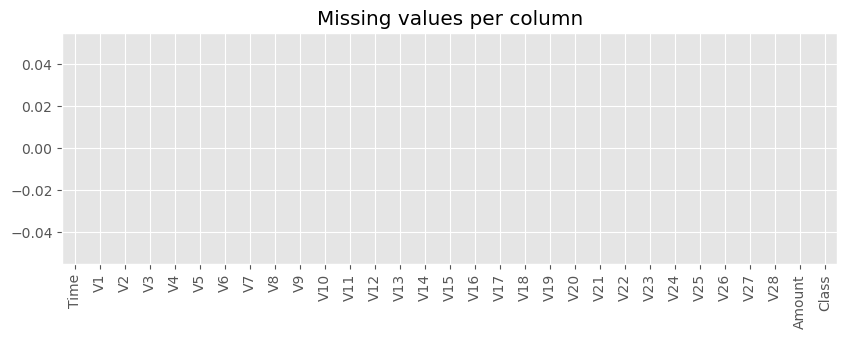

In [9]:
df.isnull().sum().plot.bar(figsize=(10,3), title="Missing values per column")

### Identify Target-class distribution

Class
0    284315
1       492
Name: count, dtype: int64
Class
0   0.9983
1   0.0017
Name: count, dtype: float64


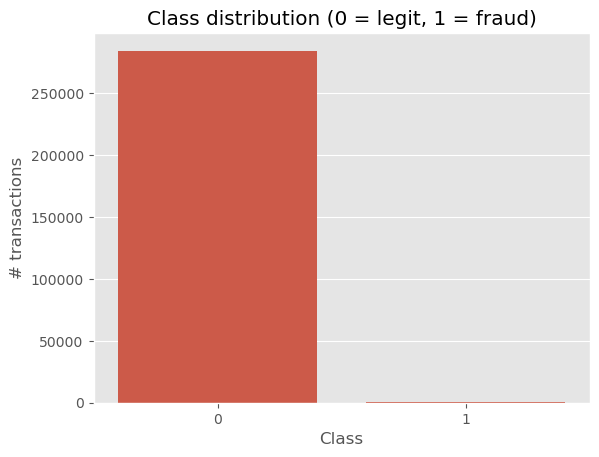

In [10]:
target_counts = df["Class"].value_counts()
target_ratio  = target_counts / len(df)

print(target_counts)
print(target_ratio)

sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title("Class distribution (0 = legit, 1 = fraud)")
plt.ylabel("# transactions")
plt.show()

### Numeric-feature distributions

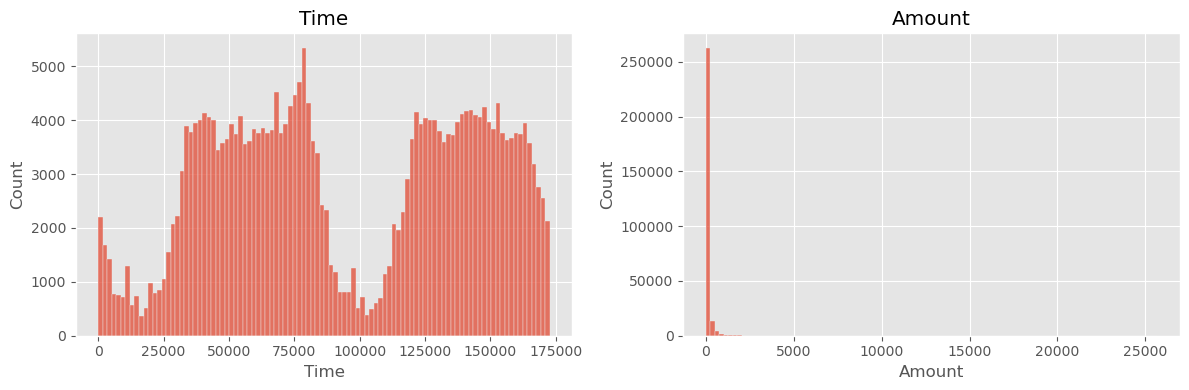

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df["Time"],  bins=100, ax=axes[0]);   axes[0].set_title("Time")
sns.histplot(df["Amount"], bins=100, ax=axes[1]);  axes[1].set_title("Amount")
plt.tight_layout()

In [6]:
df.filter(regex="^V").describe().T[["mean", "std", "min", "max"]].head()

,mean,std,min,max
V1,0.0000,1.9587,-56.4075,2.4549
V2,0.0000,1.6513,-72.7157,22.0577
V3,-0.0000,1.5163,-48.3256,9.3826
V4,0.0000,1.4159,-5.6832,16.8753
V5,0.0000,1.3802,-113.7433,34.8017


### Correlation analysis

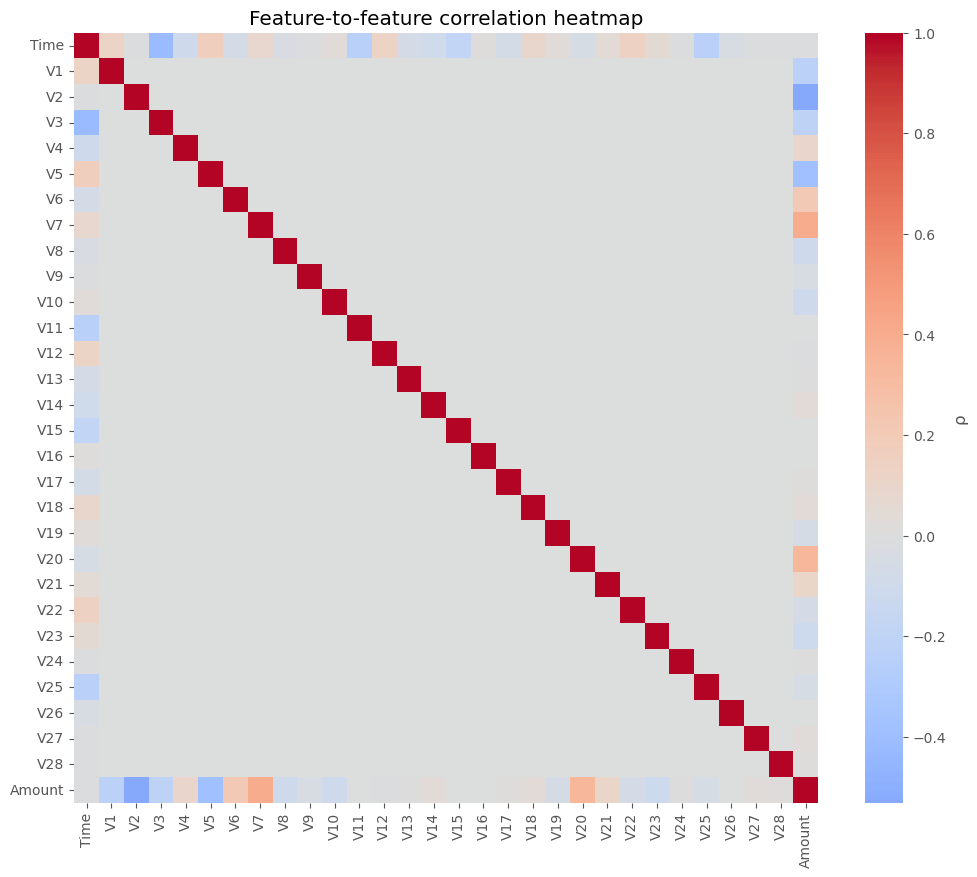

In [13]:
corr = df.drop(columns="Class").corr(method="pearson")
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={"label":"ρ"})
plt.title("Feature-to-feature correlation heatmap")
plt.show()


### Feature - Target Correlation

In [14]:
target_corr = df.corr()["Class"].abs().sort_values(ascending=False)
target_corr.head(10)

Class   1.0000
V17     0.3265
V14     0.3025
V12     0.2606
V10     0.2169
V16     0.1965
V3      0.1930
V7      0.1873
V11     0.1549
V4      0.1334
Name: Class, dtype: float64

# 3. Splitting, Scaling and Training Dataset

### Splitting data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Feature Scaling

In [5]:
# Initialize scaler
scaler = StandardScaler()

# Apply scaler on training data and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Apply Sampling


#### Smote

In [6]:
# Initialize SMOTE
smote = SMOTE(
    sampling_strategy=0.5,
    k_neighbors=3,          
    random_state=42
)

# Apply only on training data (never on test!)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

c:\Users\veyni\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Training Logistic Regression Model

#### Hyper Parameter Training using Grid Search

In [10]:
model = LogisticRegression(max_iter=1000, random_state=42)

In [11]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        # regularization strength
    'penalty': ['l1', 'l2'],             # type of regularization
    'solver': ['liblinear'],             # solver that supports both l1 and l2
    'class_weight': [None, 'balanced']   # cost-sensitive learning
}

# 4. Grid search with cross-validation
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,                         # 5-fold stratified cross-validation
    scoring='f1',                  # maximize F1-score
    n_jobs=-1,                     # use all cores
    verbose=1
)

In [12]:
# 5. Fit grid search
grid.fit(X_train_resampled, y_train_resampled)

# 6. Best model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

# 7. Evaluate on test set
y_proba = best_model.predict_proba(X_test_scaled)[:,1]
y_pred = (y_proba >= 0.99).astype(int)  # or your best_threshold from earlier

from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1 Score: 0.939514111349913
              precision    recall  f1-score   support

           0     0.9998    0.9987    0.9993     56864
           1     0.5409    0.8776    0.6693        98

    accuracy                         0.9985     56962
   macro avg     0.7703    0.9381    0.8343     56962
weighted avg     0.9990    0.9985    0.9987     56962

ROC AUC: 0.971811906388892


In [ ]:
# Initialize Logistic Regression
model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
)

# Fit the model
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=100, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

### Predicting and Evaluating model using default threshold parameters

In [8]:
# 6. Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]
# 7. Evaluation: precision, recall, f1-score, and AUC-ROC
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0     0.9999    0.9746    0.9871     56864
           1     0.0587    0.9184    0.1104        98

    accuracy                         0.9745     56962
   macro avg     0.5293    0.9465    0.5487     56962
weighted avg     0.9982    0.9745    0.9856     56962

ROC AUC Score: 0.971811906388892


### Predicting and Evaluating model using default threshold swept paramters

In [9]:
# 1. Predict probabilities
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# 2. Define thresholds to test
thresholds = np.arange(0.0, 1.01, 0.01)  # From 0 to 1 in steps of 0.01

# 3. Store metrics
scores = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    scores.append((thresh, precision, recall, f1))

# 4. Convert to DataFrame for easy analysis
import pandas as pd
scores_df = pd.DataFrame(scores, columns=["Threshold", "Precision", "Recall", "F1"])

# 5. Find the best threshold (e.g., max F1)
best_row = scores_df.loc[scores_df["F1"].idxmax()]
best_threshold = best_row["Threshold"]

print(f"Best threshold by F1: {best_threshold:.2f}")
print(best_row)

Best threshold by F1: 0.99
Threshold   0.9900
Precision   0.5409
Recall      0.8776
F1          0.6693
Name: 99, dtype: float64


### Threshold metrics plot

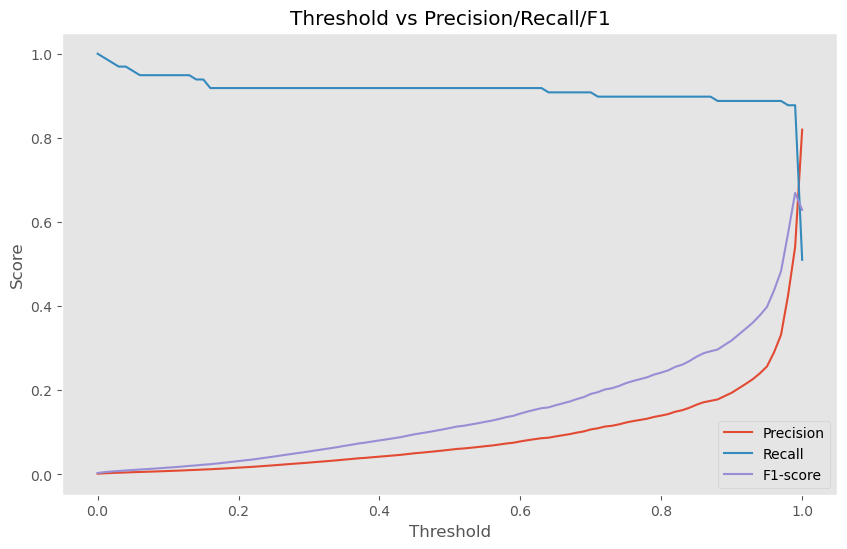

In [11]:
plt.figure(figsize=(10,6))
plt.plot(scores_df["Threshold"], scores_df["Precision"], label="Precision")
plt.plot(scores_df["Threshold"], scores_df["Recall"], label="Recall")
plt.plot(scores_df["Threshold"], scores_df["F1"], label="F1-score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision/Recall/F1")
plt.legend()
plt.grid()
plt.show()

In [13]:
y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.99).astype(int)
print(f"=== Default threshold ({best_threshold}) ===")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

=== Default threshold (0.99) ===
              precision    recall  f1-score   support

           0     0.9998    0.9987    0.9993     56864
           1     0.5409    0.8776    0.6693        98

    accuracy                         0.9985     56962
   macro avg     0.7703    0.9381    0.8343     56962
weighted avg     0.9990    0.9985    0.9987     56962

ROC AUC: 0.971811906388892


### Final Evaluation Metrics

In [14]:
print(f"Threshold: {best_threshold:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")


Threshold: 0.99
Accuracy: 0.9985
Precision: 0.5409
Recall: 0.8776
F1 Score: 0.6693
ROC AUC: 0.9718


## Confusion Matrix

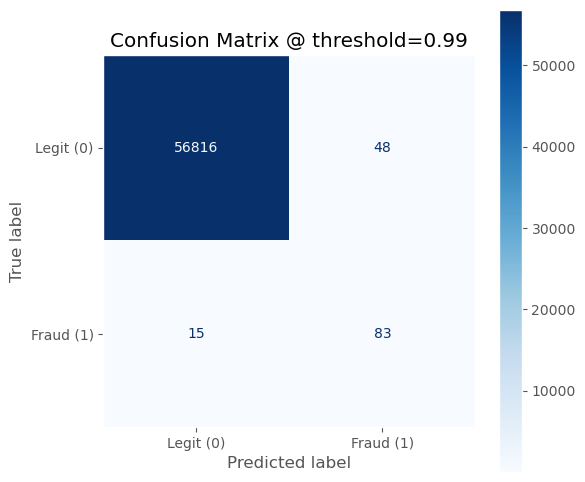

In [72]:
# 1. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit (0)", "Fraud (1)"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix @ threshold={best_threshold:.2f}")
plt.grid(False)
plt.show()

### ROC Curve

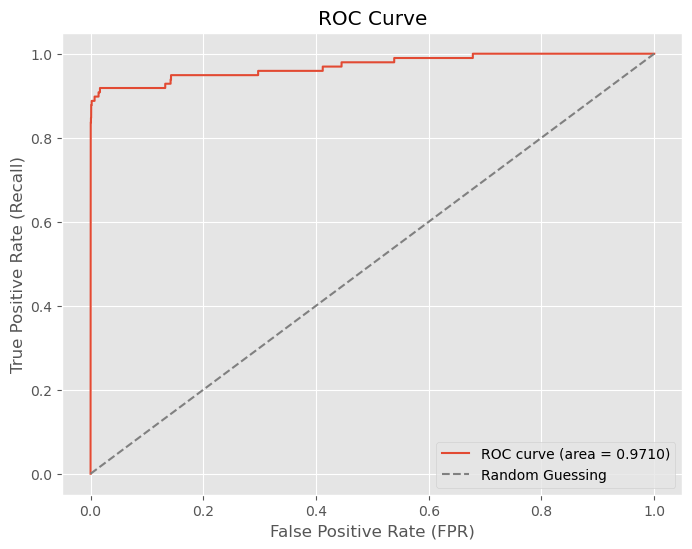

In [73]:
from sklearn.metrics import roc_curve, auc

# 1. Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 2. Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


### Precision Recall Curve

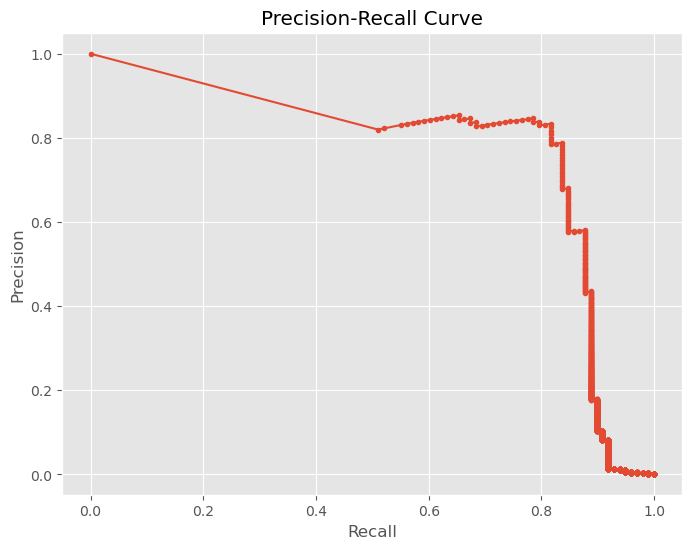

In [51]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()
